# Analyzing Network Data with Unknown Community Structure

In this tutorial, we'll walk you through the process of analyzing network data when you suspect a community structure exists but aren't sure what kind. We'll explore what to do if the inferred latent variables aren't informative and how to improve results by better initializing parameters. A key concept in this tutorial is the assortative and disassortative structure of networks.

 

> **_Quick Recap:_** 
> - **Assortative Structure**: In an assortative network, nodes tend to connect to other nodes that are similar to them. For example, in a social network, people might be more likely to connect with others who share similar interests or characteristics.
 > - **Disassortative Structure**: In a disassortative network, nodes tend to connect to other nodes that are different from them. For example, in a biological network, certain types of proteins might be more likely to interact with proteins that have different functions.

## Inferring the Communities with No Prior Information About the Structure of the Data

In this section, we'll learn how to infer community structures without knowing if the network is assortative or disassortative.

First, we load the network data using the `build_adjacency_from_file` function from the `probinet
.input.loader` module. This function builds both the graph object and the adjacency matrix (showing node connections) from a file.

In [1]:
from probinet.input.loader import build_adjacency_from_file

# Define the file path
file_path = "inputs/network_A_200_1_3_25_10.csv"

# Load the graph object from the file
gdata = build_adjacency_from_file(
    file_path,
    ego="source",
    alter="target",
    sep=" ",
    undirected=True,
    binary=False,
)
# Print the names of the coordinates in the namedtuple gdata
print(gdata._fields)

('graph_list', 'adjacency_tensor', 'transposed_tensor', 'data_values', 'nodes', 'design_matrix')


Now that we have the data, let's print some basic statistics about the graph.

In [2]:
from probinet.input.stats import print_graph_stat

# Import the logging module
import logging

# Get the root logger and set its level to INFO
logging.getLogger().setLevel(logging.INFO)

import matplotlib.pyplot as plt

# Set the logging level for matplotlib to WARNING
logging.getLogger(plt.__name__).setLevel(logging.WARNING)

# Call the `print_graph_stat` function to print the basic
# statistics of the graphs in the list `A`.
print_graph_stat(gdata.graph_list)

INFO:root:Number of nodes = 200
INFO:root:Number of layers = 1
INFO:root:Number of edges and average degree in each layer:
INFO:root:E[0] = 2314 / <k> = 23.14
INFO:root:M[0] = 2542 - <k_weighted> = 25.420
INFO:root:Sparsity [0] = 0.058
INFO:root:Reciprocity (networkX) = 0.000


The graph has 200 nodes and one layer, with approximately 2300 edges. The average degree (the number of connections per node) is about 23. The network is undirected, therefore reciprocity is meaningless.

Now that we have an overview of the network, we can infer its community structure. We'll use the 
MTCOV {cite}`contisciani2020community` class from the `pgm.model.mtcov` module. Before running 
the algorithm, we adjust some 
key parameters, such as the number of realizations and the maximum iterations.

In [3]:
from probinet.models.mtcov import MTCOV

# Define the number of realizations
NUM_REAL = 10
MAX_ITER = 500
DECISION = 15

# Create an instance of the `MTCOV` class
mtcov_unbiased = MTCOV(num_realizations=NUM_REAL, max_iter=MAX_ITER, decision=DECISION)

Next, we run the algorithm by passing the data to the fit method of the MTCOV class. This 
method requires both the **structural data** (the connections between nodes) and a **design matrix**
 `X`, which contains attributes of the nodes that can help infer community structure. In our case,
  since we don’t have any node attributes, we pass a matrix of zeros.

In [4]:
import numpy as np

# Generate dummy data for the design matrix (zeros).
X = np.zeros((len(gdata.nodes), 2))

The algorithm also requires a `GraphData` object, which contains the structural data and the 
design matrix. We have already imported part of it. Now we need to replace the design matrix with
 a dummy one (the output given by the `build_adjacency_from_file` function contains a design 
 matrix that is set to None).

In [5]:
# Print the design matrix of the `GraphData` object
print(gdata.design_matrix)

None


In [6]:
# Replace the design matrix with the dummy data
gdata = gdata._replace(design_matrix=X)

We fix the number of communities to 3 and set the gamma parameter to 0, effectively ignoring any information in the design matrix.

In [7]:
# Define the number of communities and the gamma parameter
K = 3
GAMMA = 0

Since we have no prior knowledge of the network's structure, we run the algorithm without any bias. To achieve this, we set the assortative parameter to False. This tells the algorithm not to enforce an assortative structure for the network, but it does not prevent inferring such structure if it is the optimal. 

In [8]:
# Define the assortative parameter
ASSORTATIVE = False

In [9]:
# Run the `MTCOV` model
mtcov_unbiased.fit(
    gdata,
    gamma=GAMMA,
    K=3,
    nodes=gdata.nodes,
    out_inference=False,
    initialization=0,
    assortative=ASSORTATIVE,
    undirected=True,
);

INFO:root:gamma = 0


After running the algorithm, we can examine the inferred latent variables by plotting them.

In [10]:
import matplotlib.pyplot as plt


def plot_matrices(u, v, w):
    fig, ax = plt.subplots(1, 3, figsize=(11, 3))

    # Plot u
    plot0 = ax[0].matshow(u, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    fig.colorbar(
        plot0,
        ax=ax[0],
        ticks=np.arange(0, 1.1, 0.25),
    )
    ax[0].axis("off")
    ax[0].set_title(r"$U$", fontsize=15)

    # Plot v
    plot1 = ax[1].matshow(v, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    fig.colorbar(
        plot1,
        ax=ax[1],
        ticks=np.arange(0, 1.1, 0.25),
    )
    ax[1].axis("off")
    ax[1].set_title(r"$V$", fontsize=15)

    # Plot w
    try:
        plot2 = ax[2].matshow(w[0], aspect="auto", cmap="Blues")
    except TypeError:
        w = np.diag(w.flatten()).reshape((1, 3, 3))
        plot2 = ax[2].matshow(w[0], aspect="auto", cmap="Blues")
    fig.colorbar(
        plot2,
        ax=ax[2],
        ticks=np.arange(
            np.round(np.min(w[0]), 2), np.round(np.max(w[0]), 2) + 0.15, 0.15
        ),
    )
    ax[2].axis("off")
    ax[2].set_title(r"$W$", fontsize=15)

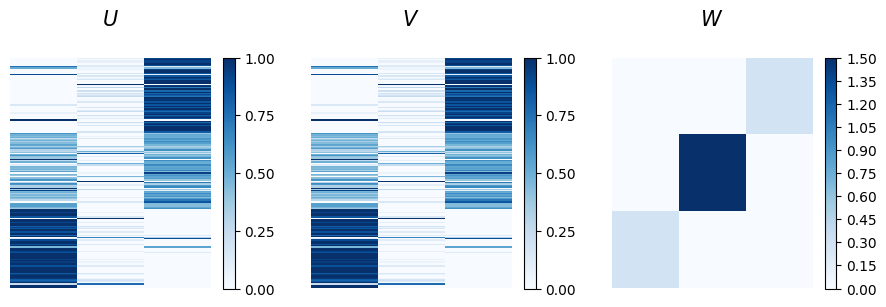

In [11]:
plot_matrices(
    mtcov_unbiased.u,
    mtcov_unbiased.v,
    mtcov_unbiased.w,
)

The `u` and `v` matrices represent node memberships for outgoing and incoming communities, respectively. Here, they are identical since the network is undirected. The plot shows that the top nodes predominantly belong to the third community, while the bottom nodes are mainly part of the first. The nodes in the middle exhibit instead mixed memberships across these groups. Looking at the affinity matrix `w`, we observe that the strongest connections are between nodes in the second community, although this community is small and shows high mixed membership levels. However, we can also notice that nodes in the first community interact exclusively with nodes in the third, hinting at a disassortative structure.

Even though there is some indication of a disassortative structure, it is not clear, and the 
mixed membership values make interpretation challenging. This may be due to the algorithm getting
 trapped in a local minimum. In this case, we ran the algorithm with a random initialization of 
 the latent variables, and with no bias toward any specific structure. This raises the question: can we improve the approach? The answer is yes. For example, if we suspect a disassortative structure, we could introduce a bias in the model to guide it in that direction.

To do this, we generate new matrices for `u`, `v`, `beta`, and `w` (the latent variables normally
 inferred by the model) and 
save them to a file.
 To bias the algorithm towards a disassortative structure, we set the diagonal of the `w` matrix to a small value.

In [12]:
# Fix the random seed for reproducibility
np.random.seed(1)
N = len(gdata.nodes)
# Generate initial guesses for u and v
initial_u = np.random.random_sample((N, K))
initial_v = np.random.random_sample((N, K))
# Generate random sample for w of size KxK
initial_w = np.random.random_sample((1, K, K))
# Make the diagonal almost zero by multiplying it by a small number
np.fill_diagonal(initial_w[0], 0.01)
# Generate a dummy beta
initial_beta = np.zeros((K, 2))

In [13]:
from pathlib import Path

# Define the output file path
outfile = Path("outputs/theta_for_init.npz")

# Save the variables to a .npz file
np.savez_compressed(
    outfile, u=initial_u, v=initial_v, w=initial_w, beta=initial_beta, nodes=gdata.nodes
)

Now we’re ready to run the algorithm! In addition to setting key parameters, we can also specify the file path where the initial guesses for the latent variables are stored.

In [14]:
# Instantiate the `MTCOV` class
mtcov_disassortative = MTCOV(
    num_realizations=NUM_REAL, max_iter=MAX_ITER, decision=DECISION
)

# Define the assortative parameter
ASSORTATIVE = False

# Run the `MTCOV` model
mtcov_disassortative.fit(
    gdata,
    gamma=GAMMA,
    K=K,
    nodes=gdata.nodes,
    out_inference=False,
    assortative=ASSORTATIVE,
    undirected=True,
    initialization=1,
    files=outfile,
);

INFO:root:gamma = 0


Let’s visualize the results by plotting the latent variables.



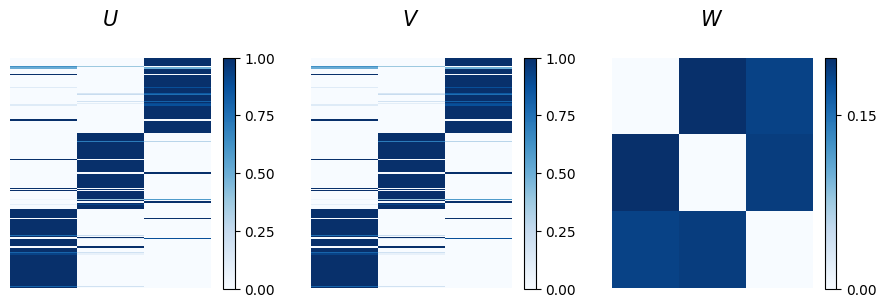

In [15]:
plot_matrices(
    mtcov_disassortative.u,
    mtcov_disassortative.v,
    mtcov_disassortative.w,
)

Good news! The algorithm successfully escaped the local minimum and found a more informative set of latent variables. The `w` matrix now shows a clear disassortative structure, with diagonal values close to zero, indicating weak intra-community connections. Moreover, the `u` and `v` matrices reveal a distinct assignment of nodes into the three communities.

To complete the analysis, we show what would happen if we force the model to look for an assortative community structure. This can be done simply by setting the assortative flag to True.

In [16]:
# Instantiate the `MTCOV` class
mtcov_assortative = MTCOV(
    num_realizations=NUM_REAL, max_iter=MAX_ITER, decision=DECISION
)

# Define the assortative parameter
ASSORTATIVE = True

# Run the `MTCOV` model
mtcov_assortative.fit(
    gdata,
    gamma=GAMMA,
    K=K,
    nodes=gdata.nodes,
    out_inference=False,
    initialization=0,
    assortative=ASSORTATIVE,
    undirected=True,
);

INFO:root:gamma = 0


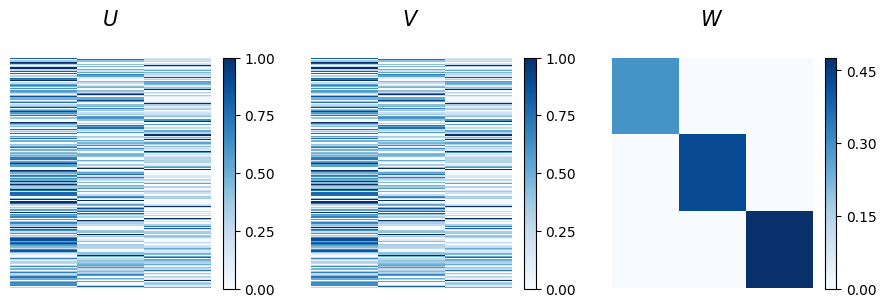

In [17]:
plot_matrices(
    mtcov_assortative.u,
    mtcov_assortative.v,
    mtcov_assortative.w,
)

The affinity matrix `w` display the constrained assortative structure, while the node memberships present a mixed partition that is difficult to interpret from this visualization alone.

So far the analysis has been done visually, but we can also quantify the quality of the inferred community structure using various metrics.
For example, we could compare the log-likelihood of different models to identify the one with the lowest (best) value. 

Alternatively, we could use reconstruction metrics, such as the L1 loss and AUC, to compare the input adjacency matrix against the inferred matrices.
For this option, we need to construct the matrices from the inferred latent variables. This can be done using the `lambda0_full` function from the `pgm.output.evaluate` module, which calculates the matrix `M` based from the latent variables `u`, `v`, and `w`. The following cell demonstrates how to compute and visualize these matrices.


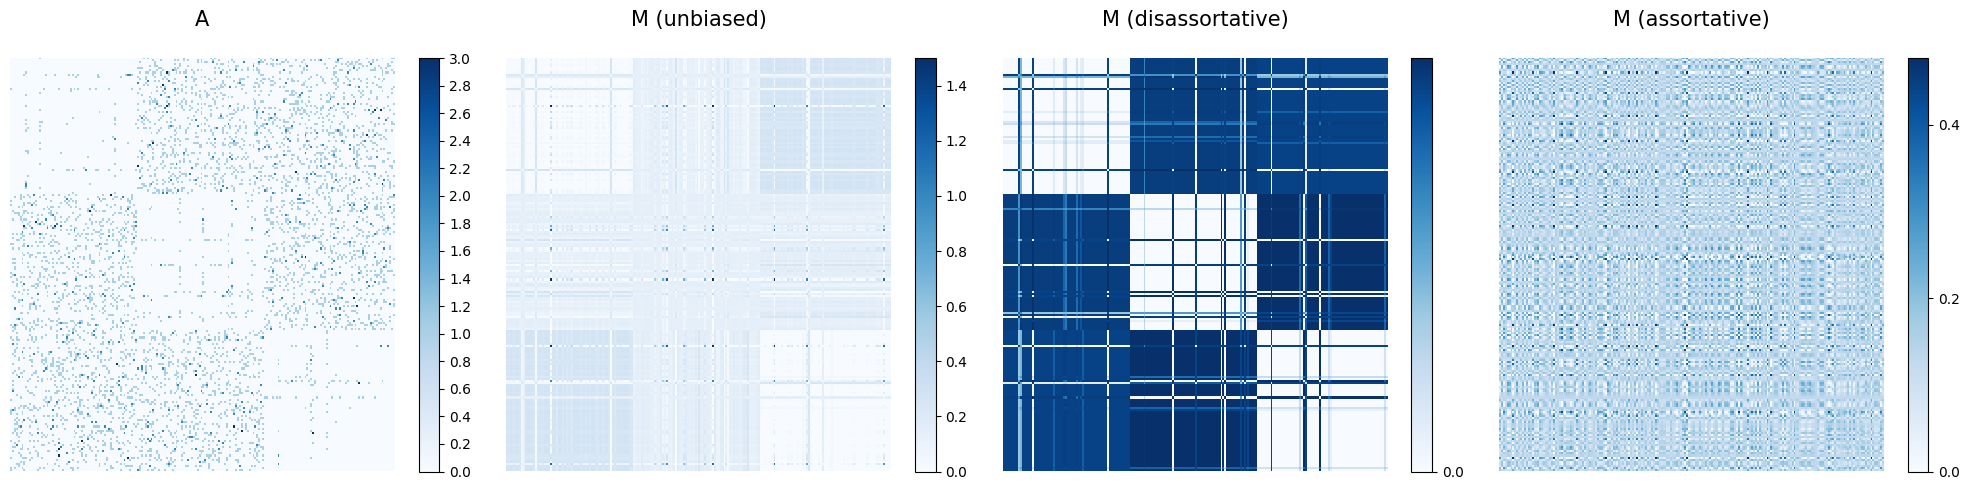

In [18]:
import networkx as nx
from probinet.evaluation.expectation_computation import compute_mean_lambda0


def plot_matrix(ax, matrix, title):
    plot = ax.matshow(matrix, aspect="auto", cmap="Blues")
    fig.colorbar(
        plot,
        ax=ax,
        ticks=np.arange(
            np.round(np.min(matrix), 1), np.round(np.max(matrix), 1) + 0.2, 0.2
        ),
    )
    ax.axis("off")
    ax.set_title(title, fontsize=15)


# Plotting the matrices
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Plot matrix A
adjacency_matrix = nx.to_scipy_sparse_array(gdata.graph_list[0])
adjacency_matrix = adjacency_matrix.toarray()
plot_matrix(ax[0], adjacency_matrix, "A")

# Plot matrix M from mtcov_unbiased
M_unbiased = compute_mean_lambda0(mtcov_unbiased.u, mtcov_unbiased.v, mtcov_unbiased.w)[
    0
]
plot_matrix(ax[1], M_unbiased, "M (unbiased)")

# Plot matrix M from mtcov_disassortative
M_disassortative = compute_mean_lambda0(
    mtcov_disassortative.u, mtcov_disassortative.v, mtcov_disassortative.w
)[0]
plot_matrix(ax[2], M_disassortative, "M (disassortative)")

# Plot matrix M from mtcov_assortative
M_assortative = compute_mean_lambda0(
    mtcov_assortative.u, mtcov_assortative.v, mtcov_assortative.w
)[0]
plot_matrix(ax[3], M_assortative, "M (assortative)")

plt.tight_layout()
plt.show()

The first matrix shows the adjacency matrix `A`, capturing the connections between nodes. 
The other matrices display the inferred matrices `M` (representing the expected values) for the three cases we explored. We 
can now summarize the models' performance with the log-likelihood, the L1 loss, and the AUC.

In [19]:
import pandas as pd
from probinet.evaluation.likelihood import log_likelihood_given_model
from probinet.evaluation.expectation_computation import compute_L1loss
from probinet.evaluation.link_prediction import compute_link_prediction_AUC

# Calculate the metrics
results = {
    "Matrix": ["M (unbiased)", "M (disassortative)", "M (assortative)"],
    "Log-likelihood": [
        log_likelihood_given_model(mtcov_unbiased, gdata.adjacency_tensor),
        log_likelihood_given_model(mtcov_disassortative, gdata.adjacency_tensor),
        log_likelihood_given_model(mtcov_assortative, gdata.adjacency_tensor),
    ],
    "L1 Loss": [
        compute_L1loss(adjacency_matrix, M_unbiased),
        compute_L1loss(adjacency_matrix, M_disassortative),
        compute_L1loss(adjacency_matrix, M_assortative),
    ],
    "AUC": [
        compute_link_prediction_AUC(adjacency_matrix, M_unbiased),
        compute_link_prediction_AUC(adjacency_matrix, M_disassortative),
        compute_link_prediction_AUC(adjacency_matrix, M_assortative),
    ],
}

# Create a DataFrame
df_results = pd.DataFrame(results)

# Round the numbers to three decimal places
df_results = df_results.round(3)

df_results

,Matrix,Log-likelihood,L1 Loss,AUC
0,M (unbiased),-14226.442,0.213,0.684
1,M (disassortative),-13653.129,0.211,0.699
2,M (assortative),-14924.255,0.219,0.629


As shown in the table, the model biased towards a disassortative structure performs the best, 
achieving the lowest log-likelihood, the lowest L1 loss, and the highest AUC. However, the differences compared to the unbiased model are minimal, indicating that the parameters inferred in the unbiased model were close to optimal. Conversely, the model biased towards an assortative structure performs the worst.

## Summary

In this tutorial, we explored how to infer community structures in network data without prior 
knowledge of whether the network is assortative or disassortative. Initially, we ran the 
algorithm with random initialization and no bias, which resulted in unclear latent 
variables. By adjusting the parameters and providing a better initialization, we guided the 
algorithm out of a local minimum, successfully revealing a stronger community structure. 
We also quantified the quality of the inferred structures by comparing the models' log-likelihood and their perfomance in reconstruction. For the latter option, we calculated the L1 loss and the AUC between the adjacency matrix and the inferred 
 ones.
